In [1405]:
# !pip install catboost

In [1406]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import catboost as catb

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [1407]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [1408]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name], random_state=17)
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1, random_state=17) 

In [1409]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [1410]:
DATASET_PATH = '../course_project_train.csv'
PREDICT_PATH = '../course_project_test.csv'

### Загрузка данных

In [1411]:
df = pd.read_csv(DATASET_PATH)
df = reduce_mem_usage(df)
df.head().T

Memory usage of dataframe is 0.97 MB
Memory usage after optimization is: 0.38 MB
Decreased by 60.9%


,0,1,2,3,4
Home Ownership,Own Home,Own Home,Home Mortgage,Own Home,Rent
Annual Income,482087.0,1025487.0,751412.0,805068.0,776264.0
Years in current job,NaN,10+ years,8 years,6 years,8 years
Tax Liens,0.0,0.0,0.0,0.0,0.0
Number of Open Accounts,11.0,15.0,11.0,8.0,13.0
Years of Credit History,26.299999,15.3,35.0,22.5,13.6
Maximum Open Credit,685960.0,1181730.0,1182434.0,147400.0,385836.0
Number of Credit Problems,1.0,0.0,0.0,1.0,1.0
Months since last delinquent,NaN,NaN,NaN,NaN,NaN
Bankruptcies,1.0,0.0,0.0,1.0,0.0


In [1412]:
df.shape

(7500, 17)

In [1413]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Home Ownership                7500 non-null   category
 1   Annual Income                 5943 non-null   float32 
 2   Years in current job          7129 non-null   category
 3   Tax Liens                     7500 non-null   float32 
 4   Number of Open Accounts       7500 non-null   float32 
 5   Years of Credit History       7500 non-null   float32 
 6   Maximum Open Credit           7500 non-null   float32 
 7   Number of Credit Problems     7500 non-null   float32 
 8   Months since last delinquent  3419 non-null   float32 
 9   Bankruptcies                  7486 non-null   float32 
 10  Purpose                       7500 non-null   category
 11  Term                          7500 non-null   category
 12  Current Loan Amount           7500 non-null   fl

### Обзор данных

**Обзор целевой переменной**

In [1414]:
df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

Наблюдаем дисбаланс классов, его нужно будет исправить

**Обзор количественных признаков**

In [1415]:
df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.0000,3419.000000,7486.000000,7500.0,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366390e+06,0.030133,11.130934,18.317446,9.451526e+05,0.1700,34.692600,0.117152,11873135.0,2.898332e+05,18314.453125,1151.087524,0.281733
std,8.453384e+05,0.271613,4.908937,7.041938,1.602614e+07,0.4986,21.688801,0.347197,31926302.0,3.178713e+05,11926.758789,1604.447510,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.0000,0.000000,0.000000,11242.0,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.0000,16.000000,0.000000,180169.0,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.0000,32.000000,0.000000,309573.0,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.799999,7.935015e+05,0.0000,50.000000,0.000000,519882.0,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700001,1.304726e+09,7.0000,118.000000,4.000000,100000000.0,6.506797e+06,136679.000000,7510.000000,1.000000


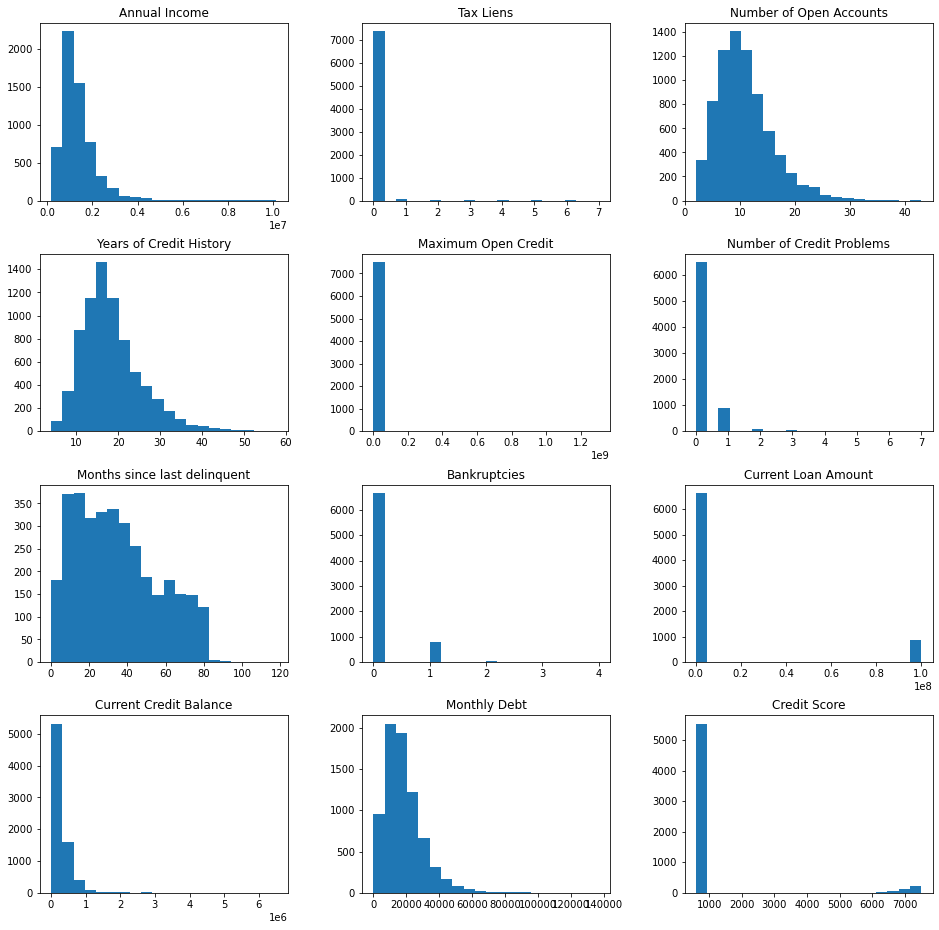

In [1416]:
df.drop('Credit Default', axis=1).hist(figsize=(16,16), bins=20, grid=False);

**Обзор номинативных признаков**

In [1417]:
for cat_colname in df.select_dtypes(include='category').columns:
    print(str(cat_colname) + '\n\n' + str(df[cat_colname].value_counts()) + '\n' + '*' * 40 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64
****************************************

Te

### Обработка пропусков

In [1418]:
df.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [1419]:
df['Bankruptcies'].fillna(0, inplace=True)

#### Years in current job

In [1420]:
df['YICJ_nan'] = 0
df.loc[df['Years in current job'].isna(), 'YICJ_nan'] = 1

Создадим новую категорию для пропусков и преобразуем категориальный признак в числовой

In [1421]:
df['Years in current job'].cat.add_categories('nan', inplace=True)
df['Years in current job'].fillna('nan', inplace=True)

In [1422]:
mapping_dict = {
    "Years in current job": {
        "10+ years": 10,
        "9 years": 9,
        "8 years": 8,
        "7 years": 7,
        "6 years": 6,
        "5 years": 5,
        "4 years": 4,
        "3 years": 3,
        "2 years": 2,
        "1 year": 1,
        "< 1 year": 0,
        "nan": 0
    }
}

In [1423]:
df = df.replace(mapping_dict)
df['Years in current job'] = df['Years in current job'].astype('int')

#### Months since last delinquent

In [1424]:
df['MSLD_nan'] = 0
df.loc[df['Months since last delinquent'].isna(), 'MSLD_nan'] = 1
df[df['MSLD_nan'] == 1].head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,YICJ_nan,MSLD_nan
0,Own Home,482087.0,0,0.0,11.0,26.299999,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,100000000.0,47386.0,7914.0,749.0,0,1,1
1,Own Home,1025487.0,10,0.0,15.0,15.300000,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1,0,1
2,Home Mortgage,751412.0,8,0.0,11.0,35.000000,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,100000000.0,308389.0,13651.0,742.0,0,0,1
3,Own Home,805068.0,6,0.0,8.0,22.500000,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0,0,1
4,Rent,776264.0,8,0.0,13.0,13.600000,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0,0,1


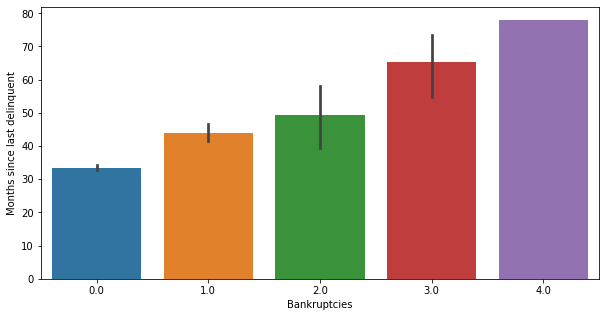

In [1425]:
plt.figure(figsize = (10,5))
sns.barplot(y = df['Months since last delinquent'], x = df['Bankruptcies'], data = df)

plt.show()

Прослеживается положительная корреляция между кол-вом банкротств и кол-вом месяцев с последней просрочки платежа

Заменим пропуски в кол-ве месяцев просрочки в соответствии с кол-вом банкротств

In [1426]:
df.groupby('Bankruptcies')['Months since last delinquent'].agg([np.mean, np.median, np.size])

,mean,median,size
Bankruptcies,,,
0.0,33.509991,31.0,6674.0
1.0,43.994202,46.0,786.0
2.0,49.437500,50.5,31.0
3.0,65.250000,67.0,7.0
4.0,78.000000,78.0,2.0


In [1427]:
df['Months since last delinquent'] = \
df.groupby('Bankruptcies')['Months since last delinquent'].transform(lambda x: x.fillna(x.median()))

In [1428]:
df['Months since last delinquent'].isna().sum()

0

In [1429]:
# на случай если все же остались пропуски
df['Months since last delinquent'].fillna(df['Months since last delinquent'].median(), inplace=True)

#### Annual Income и Credit Score

In [1430]:
condition = (df['Annual Income'].isna() & df['Credit Score'].isna())
df.loc[condition].shape

(1557, 19)

In [1431]:
df['AI_CS_nan'] = 0
df.loc[df['Annual Income'].isna(), 'AI_CS_nan'] = 1

In [1432]:
df['Annual Income'].fillna(df['Annual Income'].median(), inplace=True)

In [1433]:
df['Credit Score'].fillna(df['Credit Score'].median(), inplace=True)

In [1434]:
df.isna().sum().sum()

0

### Обработка выбросов

#### Maximum Open Credit

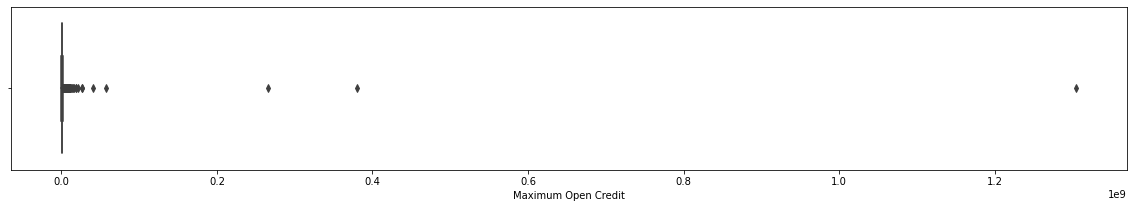

In [1435]:
plt.figure(figsize=(20, 3))

plt.subplot()
sns.boxplot(df['Maximum Open Credit'], whis=1.5)
plt.xlabel('Maximum Open Credit')

plt.show()

In [1436]:
moc_max = df['Maximum Open Credit'].quantile(0.999)
condition = df['Maximum Open Credit'] > moc_max
df.loc[condition, 'Maximum Open Credit'] = df['Maximum Open Credit'].median()

#### Current Loan Amount

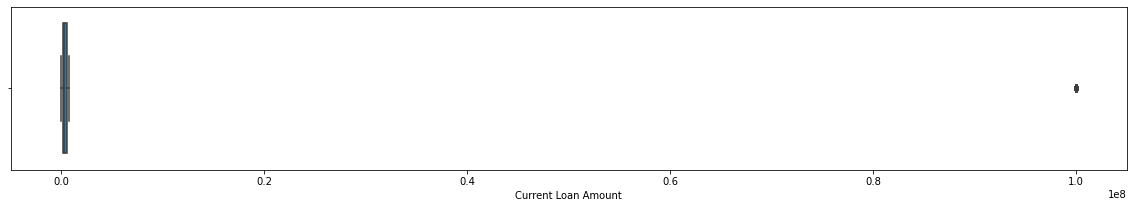

In [1437]:
plt.figure(figsize=(20, 3))

plt.subplot()
sns.boxplot(df['Current Loan Amount'], whis=1.5)
plt.xlabel('Current Loan Amount')

plt.show()

In [1438]:
df['Current Loan Amount'].value_counts()

100000000.0    870
89298.0          6
218064.0         6
216106.0         5
265826.0         5
              ... 
222860.0         1
104324.0         1
201080.0         1
427812.0         1
191136.0         1
Name: Current Loan Amount, Length: 5386, dtype: int64

Наблюдаем ряд наблюдений со странным максимальным значением, заменим их на медиану, вычисленную без учета значений-выбросов

In [1439]:
df['CLA_outlier'] = 0
df.loc[df['Current Loan Amount'] == df['Current Loan Amount'].max(), 'CLA_outlier'] = 1

In [1440]:
condition = df['Current Loan Amount'] < df['Current Loan Amount'].max()
df_cla_median = df[condition]['Current Loan Amount'].median()
df_cla_median

265826.0

In [1441]:
df.loc[df['Current Loan Amount'] == df['Current Loan Amount'].max(), 'Current Loan Amount'] = df_cla_median

#### Credit Score

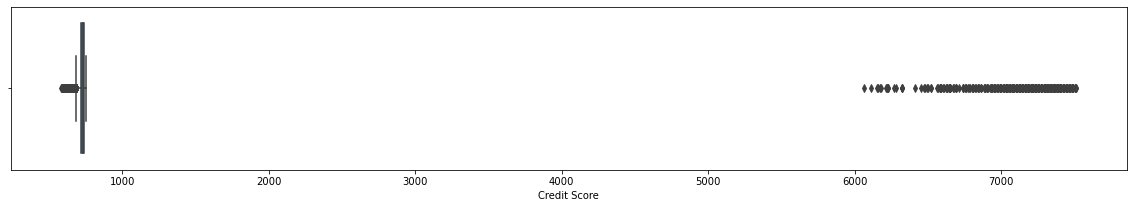

In [1442]:
plt.figure(figsize=(20, 3))

plt.subplot()
sns.boxplot(df['Credit Score'], whis=1.5)
plt.xlabel('Credit Score')

plt.show()

Наблюдаем ряд странных наблюдений со значением Credit Score > 6000, сделаем для них отдельный признак, заменять не будем

In [1443]:
df['CS_outlier'] = 0
df.loc[df['Credit Score'] > 6000, 'CS_outlier'] = 1

**Корреляция с признаками**

In [1444]:
TARGET_NAME = 'Credit Default'
FEATURE_NAMES = df.columns.drop(TARGET_NAME).tolist()

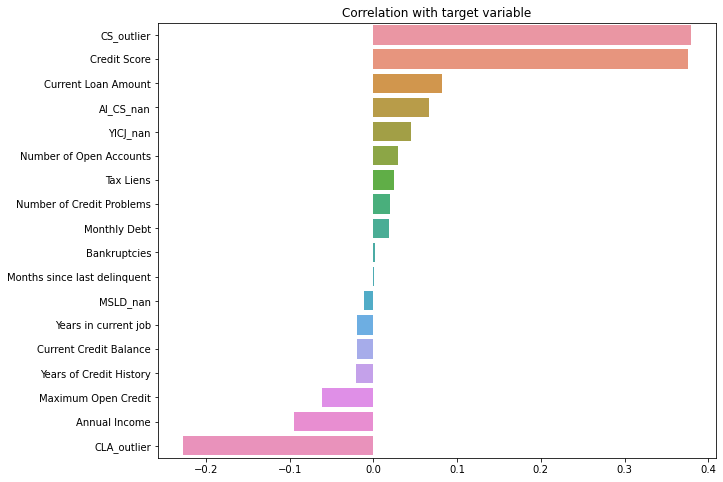

In [1445]:
corr_with_target = df[FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

In [1446]:
NUM_FEATURE_NAMES = df.select_dtypes(include=['number']).columns.tolist()
CAT_FEATURE_NAMES = df.select_dtypes(include=['category']).columns.tolist()

NUM_FEATURE_NAMES, CAT_FEATURE_NAMES

(['Annual Income',
  'Years in current job',
  'Tax Liens',
  'Number of Open Accounts',
  'Years of Credit History',
  'Maximum Open Credit',
  'Number of Credit Problems',
  'Months since last delinquent',
  'Bankruptcies',
  'Current Loan Amount',
  'Current Credit Balance',
  'Monthly Debt',
  'Credit Score',
  'Credit Default',
  'YICJ_nan',
  'MSLD_nan',
  'AI_CS_nan',
  'CLA_outlier',
  'CS_outlier'],
 ['Home Ownership', 'Purpose', 'Term'])

### Разбиение на train и test

In [1447]:
X = df[FEATURE_NAMES]
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, random_state=21)

### Балансировка целевой переменной

In [1448]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    4304
1    3392
Name: Credit Default, dtype: int64

In [1449]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

### Построение и оценка модели

In [1450]:
cat_features = CAT_FEATURE_NAMES

final_model = catb.CatBoostClassifier(n_estimators=30, max_depth=2, learning_rate=0.346,
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train, cat_features)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.71      0.85      0.77      4304
           1       0.74      0.55      0.63      3392

    accuracy                           0.72      7696
   macro avg       0.72      0.70      0.70      7696
weighted avg       0.72      0.72      0.71      7696

TEST

              precision    recall  f1-score   support

           0       0.82      0.83      0.83      1083
           1       0.55      0.53      0.54       417

    accuracy                           0.75      1500
   macro avg       0.69      0.68      0.68      1500
weighted avg       0.75      0.75      0.75      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               902  181
1               195  222


In [1451]:
f1_score(y_test, y_test_pred)

0.5414634146341464

#### Веса признаков

In [1452]:
feature_importances = pd.DataFrame(
    zip(X.columns, final_model.get_feature_importance()),
    columns=['feature_name', 'importance']
)

feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances.head(20)

,feature_name,importance
19,CLA_outlier,42.245284
20,CS_outlier,40.521790
15,Credit Score,9.898331
11,Term,2.085947
1,Annual Income,1.937749
6,Maximum Open Credit,0.774700
14,Monthly Debt,0.502833
12,Current Loan Amount,0.389705
0,Home Ownership,0.313852
4,Number of Open Accounts,0.300713


### Подготовка результирующей выборки

#### Импорт данных

In [1453]:
test_df = pd.read_csv(PREDICT_PATH, sep=',')
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 0.31 MB
Memory usage after optimization is: 0.13 MB
Decreased by 58.9%


In [1454]:
test_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,1987.00,2500.00000,2500.000000,2500.000000,2.500000e+03,2500.000000,1142.000000,2497.000000,2500.0,2.500000e+03,2500.000000,1987.000000
mean,1366920.75,0.03520,11.184400,18.325901,7.105701e+05,0.162000,34.181259,0.106928,12155693.0,2.963965e+05,18271.304688,1234.516846
std,917124.50,0.38629,4.852777,7.254657,1.511983e+06,0.559895,22.024271,0.357191,32261024.0,3.783021e+05,11543.883789,1740.216553
min,106533.00,0.00000,1.000000,3.900000,0.000000e+00,0.000000,0.000000,0.000000,15422.0,0.000000e+00,93.000000,585.000000
25%,852311.50,0.00000,8.000000,13.400000,2.785860e+05,0.000000,16.000000,0.000000,187126.5,1.101145e+05,10024.750000,710.000000
50%,1178475.00,0.00000,10.000000,17.000000,4.786760e+05,0.000000,30.000000,0.000000,322366.0,2.073850e+05,16642.500000,731.000000
75%,1629734.50,0.00000,14.000000,22.100000,8.025985e+05,0.000000,50.000000,0.000000,522582.5,3.663485e+05,24146.000000,743.000000
max,14975610.00,15.00000,48.000000,53.400002,5.448438e+07,15.000000,82.000000,5.000000,100000000.0,6.030087e+06,93555.000000,7480.000000


In [1455]:
test_df.isna().sum().sum()

2473

#### Обработка данных

In [1456]:
# Bankruptcies - пропуски
test_df['Bankruptcies'].fillna(0, inplace=True)

# Years in current job - пропуски, преобразуем в числовой признак
test_df['YICJ_nan'] = 0
test_df.loc[test_df['Years in current job'].isna(), 'YICJ_nan'] = 1
test_df['Years in current job'].cat.add_categories('nan', inplace=True)
test_df['Years in current job'].fillna('nan', inplace=True)
test_df = test_df.replace(mapping_dict)
test_df['Years in current job'] = test_df['Years in current job'].astype('int')

# Months since last delinquent - пропуски
test_df['MSLD_nan'] = 0
test_df.loc[test_df['Months since last delinquent'].isna(), 'MSLD_nan'] = 1
test_df['Months since last delinquent'] = \
test_df.groupby('Bankruptcies')['Months since last delinquent'].transform(lambda x: x.fillna(x.median()))
test_df['Months since last delinquent'].fillna(test_df['Months since last delinquent'].median(), inplace=True)

# Annual Income и Credit Score - пропуски
test_df['AI_CS_nan'] = 0
test_df.loc[test_df['Annual Income'].isna(), 'AI_CS_nan'] = 1
test_df['Annual Income'].fillna(test_df['Annual Income'].median(), inplace=True)
test_df['Credit Score'].fillna(test_df['Credit Score'].median(), inplace=True)

# Maximum Open Credit - обработка выбросов
moc_max = test_df['Maximum Open Credit'].quantile(0.999)
test_df.loc[test_df['Maximum Open Credit'] > moc_max, 'Maximum Open Credit'] = test_df['Maximum Open Credit'].median()

# Current Loan Amount - обработка выбросов
test_df['CLA_outlier'] = 0
test_df.loc[test_df['Current Loan Amount'] == test_df['Current Loan Amount'].max(), 'CLA_outlier'] = 1
test_df_cla_median = test_df[test_df['Current Loan Amount'] < test_df['Current Loan Amount'].max()]['Current Loan Amount'].median()
test_df.loc[test_df['Current Loan Amount'] == test_df['Current Loan Amount'].max(), 'Current Loan Amount'] = test_df_cla_median

# Credit Score - обработка выбросов
test_df['CS_outlier'] = 0
test_df.loc[test_df['Credit Score'] > 6000, 'CS_outlier'] = 1

In [1457]:
test_df.isna().sum().sum()

0

#### Сохранение результатов предсказаний финальной модели

In [1458]:
y_predict = final_model.predict(test_df)

In [1459]:
preds_final = pd.DataFrame({'Id': np.arange(0,y_predict.shape[0]), 'Credit Default': y_predict})
preds_final.to_csv('./ISeliugina_predictions.csv', index=False, encoding='utf-8', sep=',')
preds_final.head(10)

,Id,Credit Default
0,0,0
1,1,1
2,2,1
3,3,0
4,4,0
5,5,0
6,6,0
7,7,1
8,8,0
9,9,0
